Installing package into '/usr/local/lib/R/site-library'
(as 'lib' is unspecified)
also installing the dependency 'statmod'



In [3]:
library("rio")
library("ggplot2")
library("forecast")
library("tseries")
library("tidyverse")
library(readxl)
library(zoo)

Loading required package: statmod
MVR 1.33.0
Type MVR.news() to see new features, changes, and bug fixes

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



ERROR: Error in args(MVR): object 'MVR' not found


In [6]:
data <- read.csv("Monthly_data_cmo.csv")
data <- data.frame(data)

data <- data[order(data[,9]),]

data <- subset(data, select =-c(state_name))

In [164]:
data$arrivals_in_qtl = tsclean(ts(data[, c('arrivals_in_qtl')]))
data$min_price = tsclean(ts(data[, c('min_price')]))
data$max_price = tsclean(ts(data[, c('max_price')]))
data$modal_price = tsclean(ts(data[, c('modal_price')]))

In [90]:
season <- function(source,apmc, commodity,attribute,plot = FALSE,acf_test = FALSE ){
    data1 <- subset(source, APMC == apmc)
    data1 <- subset(data1, Commodity == commodity)
    data1$arrivals_in_qtl = tsclean(ts(data1[, c('arrivals_in_qtl')]))
    data1$min_price = tsclean(ts(data1[, c('min_price')]))
    data1$max_price = tsclean(ts(data1[, c('max_price')]))
    data1$modal_price = tsclean(ts(data1[, c('modal_price')]))

    count_ma = ts(na.omit(data1[[attribute]]),frequency = 3)
    decomp = stl(count_ma,"periodic")
    
    deseasonal_cnt <- seasadj(decomp)
    
    if(plot ==  TRUE){
        plot(decomp) 
    }
    if(acf_test == TRUE){
        print(adf.test(count_ma,alternative = "stationary"))
    }
    count_dl = diff(deseasonal_cnt,differences = 1)
}


	Augmented Dickey-Fuller Test

data:  count_ma
Dickey-Fuller = -3.5741, Lag order = 2, p-value = 0.0536
alternative hypothesis: stationary



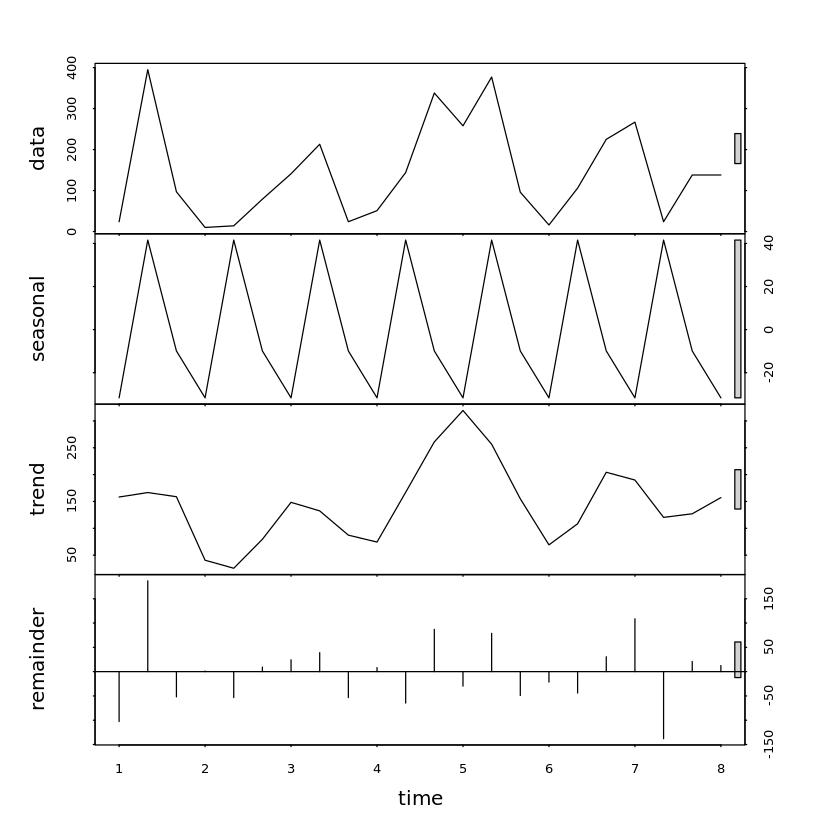

In [91]:
 a <- season(source = data, apmc = "Ahmednagar",commodity = "Bajri",attribute = "arrivals_in_qtl",plot = TRUE,acf_test = TRUE)